# 3 Семантическая сегментация

## 1 Загрузка бибилиотек

In [ ]:
import os
import pickle

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import SVG
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import random
import torch
from torchvision import models

import copy

import albumentations as A
from albumentations import CropNonEmptyMaskIfExists
from typing import List, Optional, Tuple

import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

## 2 Загрузка данных

In [ ]:
import os
notebook_path = os.path.abspath("3-stage-segm.ipynb")

In [ ]:
# Подключим gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # gpu №1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Тренировочные данные
train_df = pd.read_csv(os.path.join(os.path.dirname(notebook_path), 'train.csv'))

# Тренировочные данные разбитые по фолдам
folds_ids = pd.read_csv(os.path.join(os.path.dirname(notebook_path), 'full_train_df_folds.csv'))

In [ ]:
# Номер фолда для валидации
NUM_FOLD = 0

In [ ]:
# Разделим даннные на тренировочные (4 фолда) и валидационные (1 фолд)
train_files = folds_ids.loc[folds_ids.stratifiedkfold != NUM_FOLD, 'ImageId'].values
valid_files = folds_ids.loc[folds_ids.stratifiedkfold == NUM_FOLD, 'ImageId'].values

train_files.shape, valid_files.shape

((10054,), (2514,))

In [ ]:
# Базовая директория изображений
BASE_DIR = os.path.join(os.path.dirname(notebook_path), 'train_images')

# Размер изображения на входе
IN_DIM = (256, 1600)

# Число каналов маски (4 класса)
MASK_CHANELS = 4

In [ ]:
# Число участков
N_CROP = 5

# Размер участка
OUT_DIM = (N_CROP, 256, 320)

# Число входных каналов (RGB)
IMG_CHANELS = 3

## 3 Датасет для тренировочных данных

In [ ]:
# Преобразуем строковые rle (run-length encoding) описания масок в формат изображений
def rle2mask(rle, input_shape):
    # Ширина и высота из входной формы
    width, height = input_shape[:2]

    # Пустой массив для маски
    mask = np.zeros( width*height ).astype(np.uint8)

    # rle стока в массив чисел
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    # Заполненим маски значениями 1 в указанных участках
    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]

    return mask.reshape(height, width).T

# Многослойные маски из списка rle строк
def build_masks(rles, class_ids, input_shape, num_classes):
    masks = np.zeros((*input_shape, num_classes), dtype=np.uint8)

    # Преобразование каждой строки rle в маску и добавление в массив масок
    for rle, class_id in zip(rles, class_ids):
        if isinstance(rle, str):
            masks[:, :, class_id - 1] = rle2mask(rle, input_shape)

    return masks

In [ ]:
# Композиция аугментаций изображений
def get_training_augmentation_crop_image():
    train_transform = [

        # Отразим горизонтально / вериткально
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        # Повернем, добавим искажения
        A.Rotate(limit=3, p=0.5),
        A.OpticalDistortion(p=0.2),

        # Выберем одно из следующих действий
        A.OneOf([

            # Кроп, если маска непустая (256x320) или случайный кроп
            # (может кропнуть участок где нет маскированных пикселей)
            CropNonEmptyMaskIfExists(256, 320, p=0.7),
            A.RandomCrop(256, 320, p=0.3),
        ], p=1.0),

        # Дополнение изображения, если необходимо, до размеров (256x320),
        # заполняя границы константным значением 0
        A.PadIfNeeded(min_height=256, min_width=320,
                      border_mode=cv2.BORDER_CONSTANT,
                      value=0, p=0.3),
        #  Случайный кроп (256x320)
        A.RandomCrop(256, 320, p=1.0)
    ]
    return A.Compose(train_transform)

In [ ]:
# def get_training_augmentation_whole_image():
#     train_transform = [

#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),

#         A.Rotate(limit=3, p=0.5),

#         # Оптическое искажение (линза)
#         A.OpticalDistortion(p=0.2),

#         # Дополнение изображения, если необходимо, до размеров (256x320),
#         # заполняя границы константным значением 0
#         A.PadIfNeeded(min_height=256, min_width=320,
#                       border_mode=cv2.BORDER_CONSTANT,
#                       value=0, p=0.3),
#         #  Случайный кроп (256x1000)
#         A.RandomCrop(256, 1000, p=1.0)
#     ]
#     return A.Compose(train_transform)

In [ ]:
# Нормализуем каждый канал изображения
def get_preprocessing():
    _transform = [
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225))
    ]
    return A.Compose(_transform)

In [ ]:
class Dataset_train:
    def __init__(
            self,
            ids,
            df,
            images_dir=BASE_DIR,
            dim=IN_DIM,
            augmentation=None,
            preprocessing=None
    ):

        """
        Класс для загрузки обучающего набора данных.

        :param ids: Список имен изображений.
        :param df: DataFrame, с информацией о масках.
        :param images_dir: Директория с изображениями.
        :param dim: Размер входного изображения.
        :param augmentation: Объект аугментации изображения (по умолчанию None).
        :param preprocessing: Объект предварительной обработки изображения (по умолчанию None).
        """

        self.ids = ids
        self.df=df
        self.images_path = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.dim=dim
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        """
        Возвращает один элемент набора данных.

        :param i: Индекс элемента.
        :return: Кортеж из изображения и маски в формате тензоров.
        """
        # Прочитаем изображение
        image = cv2.imread(self.images_path[i], -1)

        # Построим маску
        mask_df = self.df[self.df['ImageId'] == self.ids[i]]
        rles = mask_df['EncodedPixels'].values
        class_ids = mask_df['ClassId'].values
        mask = build_masks(rles, class_ids, input_shape=self.dim, num_classes=MASK_CHANELS)
        mask = np.asarray(mask, np.uint8)

        # Добавим аугментацию
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Добавим препроцессинг
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']

        # Возвращаем изображение и информацию о присутствии классов
        return torch.Tensor(image).permute(2, 0, 1), torch.Tensor(mask).permute(2, 0, 1)

    def __len__(self):
        """
        Возвращает количество элементов в наборе данных.

        :return: Количество элементов.
        """
        return len(self.ids)

## 4 Датасет для валидационных данных

In [ ]:
class Dataset_valid(Dataset):
    def __init__(self,
                 ids,
                 df,
                 images_dir=BASE_DIR,
                 dim=IN_DIM,
                 preprocessing=None):
        """
        Класс для загрузки валидационного набора данных.

        :param ids: Список имен изображений.
        :param df: DataFrame, с информацией о масках.
        :param images_dir: Директория с изображениями.
        :param dim: Размер входного изображения.
        :param preprocessing: Объект предварительной обработки изображения (по умолчанию None).
        """
        self.ids = ids
        self.df = df
        self.images_path = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.dim = dim
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        """
        Возвращает нарезанное изображение и маски на участки.

        Args:
            i (int): Индекс изображения.

        Returns:
            torch.Tensor: Нарезанное изображение на учвастки.
            torch.Tensor: Нарезанная маска на участки с 4-мя слоями на каждом.
        """
        # Чтение данных
        image = cv2.imread(self.images_path[i], -1)

        # Создание маски
        mask_df = self.df[self.df['ImageId'] == self.ids[i]]
        rles = mask_df['EncodedPixels'].values
        class_ids = mask_df['ClassId'].values
        mask = build_masks(rles, class_ids, input_shape=self.dim, num_classes=MASK_CHANELS)

        # Пустые массивы для хранения обрезков
        image_crop = np.empty((*OUT_DIM, IMG_CHANELS))
        mask_crop = np.empty((*OUT_DIM, MASK_CHANELS))

        # Выполнение обрезки
        for i in range(N_CROP):
            image_crop[i] = image[:, i * OUT_DIM[2] : (i + 1) * OUT_DIM[2], :]
            mask_crop[i] = mask[:, i * OUT_DIM[2] : (i + 1) * OUT_DIM[2], :]

        # Применение препроцессинга
        if self.preprocessing:
            sample = self.preprocessing(image=image_crop, mask=mask_crop)
            image_crop, mask_crop = sample['image'], sample['mask']

        # Преобразование в тензоры
        image_crop = torch.Tensor(image_crop).permute(0, 3, 1, 2)
        mask_crop = torch.Tensor(mask_crop).permute(0, 3, 1, 2)

        return image_crop, mask_crop

    def __len__(self):
        """
        Возвращает количество изображений в датасете.

        Returns:
            int: Количество изображений.
        """
        return len(self.ids)

## 5 Даталоадер

___1 Вариант__

In [ ]:
# train_dataset = Dataset_train(
#         ids=train_files,
#         df=train_df,
#         augmentation=get_training_augmentation_crop_image(),
#         preprocessing=get_preprocessing()
# )

# valid_dataset = Dataset_valid(
#     ids=valid_files,
#     df=train_df,
#     preprocessing=get_preprocessing()
# )

# BATCH_SIZE = 16

# # Даталоадер с обработкой данных
# dataloaders = {'train': torch.utils.data.DataLoader(train_dataset,
#                                                     shuffle=True,
#                                                     num_workers=0,
#                                                     batch_size=BATCH_SIZE,
#                                                     pin_memory=True),
#                'val': torch.utils.data.DataLoader(valid_dataset,
#                                                   shuffle=False,
#                                                   num_workers=0,
#                                                   batch_size=1,
#                                                   pin_memory=True)}

# dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)*5}
# dataset_sizes['train'], dataset_sizes['val']

__Сохранение датасета и предобработанных изображений__

In [ ]:
# Сохраним датасеты
# with open(os.path.join(os.path.dirname(notebook_path), 'weights_and_logs', 'train_dataset.pkl'), 'wb') as f:
#     pickle.dump(train_dataset, f)

# with open(os.path.join(os.path.dirname(notebook_path), 'weights_and_logs', 'valid_dataset.pkl'), 'wb') as f:
#     pickle.dump(valid_dataset, f)


# # Сохраним на диск преобразованные изображения
# def save_augmented_data(dataset, save_dir):
#     os.makedirs(save_dir, exist_ok=True)

#     for i in tqdm(range(len(dataset))):
#         image, mask = dataset[i]

#         image_path = os.path.join(save_dir, f'image_{i}.pkl')
#         mask_path = os.path.join(save_dir, f'mask_{i}.pkl')

#         with open(image_path, 'wb') as f:
#             pickle.dump(image, f)

#         with open(mask_path, 'wb') as f:
#             pickle.dump(mask, f)

# augmented_save_dir = os.path.join(os.path.dirname(notebook_path), 'pre_save_data_for_train_val')
# save_augmented_data(train_dataset, os.path.join(augmented_save_dir, 'train'))
# save_augmented_data(valid_dataset, os.path.join(augmented_save_dir, 'valid'))

___2 Вариант__

In [ ]:
# Загрузим датасеты
with open(os.path.join(os.path.dirname(notebook_path), 'weights_and_logs', 'train_dataset.pkl'), 'rb') as f:
    train_dataset = pickle.load(f)

with open(os.path.join(os.path.dirname(notebook_path), 'weights_and_logs', 'valid_dataset.pkl'), 'rb') as f:
    valid_dataset = pickle.load(f)

dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)*5}
dataset_sizes['train'], dataset_sizes['val']

(10054, 12570)

In [ ]:
# Класс для загрузки данных с диска
class DiskDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.file_names = sorted(os.listdir(data_dir))
        self.images = [f for f in self.file_names if 'image' in f]
        self.masks = [f for f in self.file_names if 'mask' in f]

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.images[idx])
        mask_path = os.path.join(self.data_dir, self.masks[idx])

        with open(image_path, 'rb') as f:
            image = pickle.load(f)

        with open(mask_path, 'rb') as f:
            mask = pickle.load(f)

        return image, mask

    def __len__(self):
        return len(self.images)

In [ ]:
augmented_save_dir = os.path.join(os.path.dirname(notebook_path), 'pre_save_data_for_train_val')
train_disk_dataset = DiskDataset(os.path.join(augmented_save_dir, 'train'))
valid_disk_dataset = DiskDataset(os.path.join(augmented_save_dir, 'valid'))

In [ ]:
BATCH_SIZE = 16

# Даталоадер с загрузкой обработанных данных
dataloaders = {'train': torch.utils.data.DataLoader(train_disk_dataset,
                                                    shuffle=True,
                                                    num_workers=0,
                                                    batch_size=BATCH_SIZE,
                                                    pin_memory=True),
               'val': torch.utils.data.DataLoader(valid_disk_dataset,
                                                  shuffle=False,
                                                  num_workers=0,
                                                  batch_size=1,
                                                  pin_memory=True)}

___3 Вариант__

In [ ]:
# # Класс для переноса предобработанных данных на оперативку
# class InMemoryDataset(Dataset):
#     def __init__(self, original_dataset):
#         self.images = []
#         self.masks = []

#         for img, mask in tqdm(original_dataset):
#             self.images.append(img)
#             self.masks.append(mask)

#     def __getitem__(self, idx):
#         return self.images[idx], self.masks[idx]


#     def __len__(self):
#             return len(self.images)

# # Перенесем датасеты все сразу в память
# train_in_memory_dataset = InMemoryDataset(train_dataset)
# valid_in_memory_dataset = InMemoryDataset(valid_dataset)

# # Создадим даталоадеры для этих датасетов
# dataloaders = {
#     'train': DataLoader(train_in_memory_dataset,
#                         shuffle=True,
#                         num_workers=NUM_WORKERS,
#                         batch_size=BATCH_SIZE,
#                         pin_memory=True),
#     'val': DataLoader(valid_in_memory_dataset,
#                       shuffle=False,
#                       num_workers=NUM_WORKERS,
#                       batch_size=1,
#                       pin_memory=True)
# }

## 6 Модель

In [ ]:
# Создадим блок последовательности
class conv_block(torch.nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(conv_block, self).__init__()
        self.conv = torch.nn.Conv2d(in_size, out_size, kernel_size,
                              padding=padding, stride=stride)
        self.bn = torch.nn.BatchNorm2d(out_size)
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [ ]:
# Соберем U-Net сетку, используя архитектуру ResNet-50 как энкодер
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet50 = models.resnet50(weights=True)

        # Удобный доступ к слоям
        self.base_layers = list(self.resnet50.children())

        # Возьмем некоторые слои из модели
        self.layer0 = torch.nn.Sequential(*self.base_layers[:3]) # 64
        self.layer1 = torch.nn.Sequential(*self.base_layers[3:5]) # 256
        self.layer2 = self.base_layers[5] # 512
        self.layer3 = self.base_layers[6] # 1024
        self.layer4 = self.base_layers[7] # 2048

        # Увеличим изобр-е в 2 раза. Бин. интерпол-я (плавный переход по m, n размерности)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Звададим несколько блоков светок. Уменьшим количество каналов и увеличим разрешение.
        self.conv_up4 = torch.nn.Sequential(conv_block(3072, 256), # 2048 + 1024 = 3072
                                      conv_block(256, 256))

        self.conv_up3 = torch.nn.Sequential(conv_block(768, 128),
                                      conv_block(128, 128))

        self.conv_up2 = torch.nn.Sequential(conv_block(384, 64),
                                      conv_block(64, 64))

        self.conv_up1 = torch.nn.Sequential(conv_block(128, 32),
                                      conv_block(32, 32))

        self.conv_up0 = torch.nn.Sequential(conv_block(32, 16),
                                      conv_block(16, 16))

        # Уменьшим количество каналов до 4
        self.final_conv = torch.nn.Conv2d(16, 4, kernel_size=(1,1),
                                          stride=(1,1))

        self.final_act = torch.nn.Sigmoid()

    def forward(self, x):

        # Энкодер
        layer0 = self.layer0(x) # 64
        layer1 = self.layer1(layer0) # 256
        layer2 = self.layer2(layer1) # 512
        layer3 = self.layer3(layer2) # 1024
        layer4 = self.layer4(layer3) # 2048

        # Декодер со skip connection (пробрасываем признаки)
        x = self.upsample(layer4) # 2048
        x = torch.cat([x, layer3], dim=1) # 2048 + 1024 = 3072
        x = self.conv_up4(x) # 256

        x = self.upsample(x) # 256
        x = torch.cat([x, layer2], dim=1) # 256 + 512 = 768
        x = self.conv_up3(x) # 128

        x = self.upsample(x) # 128
        x = torch.cat([x, layer1], dim=1) # 128 + 265 = 384
        x = self.conv_up2(x) # 64

        x = self.upsample(x) # 64
        x = torch.cat([x, layer0], dim=1) # 64 + 64 = 128
        x = self.conv_up1(x) # 32

        x = self.upsample(x) # 32
        x = self.conv_up0(x) # 16

        x = self.final_conv(x) # 4
        x = self.final_act(x)

        return x

In [ ]:
model = Net()
model = model.to(device)

C:\Users\Admin\anaconda3\envs\severstal\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 7 Метрики

In [ ]:
# Коэффициент Дайса
def get_metrics(true, pred):
    # Списки метрик по классу для изображения - (5 - (объектов, участков), 4)
    dice_pos, dice_neg = [], []

    # Пройдем по всем объектам и классам
    for obj in range(pred.shape[0]): # pred.shape - (5, 4, 256, 320)
        _dice_pos, _dice_neg = [], []
        for i in range(pred.shape[1]):
            p = pred[obj][i, :, :].reshape(-1,)
            t = true[obj][i, :, :].reshape(-1,)

            if t.max() == 1:  # Если есть дефектные пиксели
                _dice_pos.append((2 * (p * t).sum()) / (p.sum() + t.sum()))
                _dice_neg.append(np.nan)
            else:  # Если дефектных пикселей нет
                _dice_pos.append(np.nan)
                _dice_neg.append(0 if p.max() == 1 else 1)

        dice_pos.append(_dice_pos)
        dice_neg.append(_dice_neg)

    return dice_pos, dice_neg

In [ ]:
# Мера Жаккара
def get_metrics_iou(true, pred):
    iou_pos, iou_neg = [], []

    for obj in range(pred.shape[0]):  # pred.shape - (5, 4, 256, 320)
        _iou_pos, _iou_neg = [], []
        for i in range(pred.shape[1]):
            p = pred[obj][i, :, :].reshape(-1,)
            t = true[obj][i, :, :].reshape(-1,)

            if t.max() == 1:  # Если есть дефектные пиксели
                intersection = (p * t).sum()
                union = p.sum() + t.sum() - intersection
                iou_score = intersection / union
                _iou_pos.append(iou_score)
                _iou_neg.append(np.nan)
            else:  # Если дефектных пикселей нет
                _iou_pos.append(np.nan)
                iou_score = 0 if p.max() == 1 else 1
                _iou_neg.append(iou_score)

        iou_pos.append(_iou_pos)
        iou_neg.append(_iou_neg)

    return iou_pos, iou_neg

## 8 Обучение

In [ ]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes,
                scheduler, device, num_epochs=25, early_stop_patience=15):
    # Временная отметка
    since = time.time()

    # Глубокая копия весов модели
    best_model_wts = copy.deepcopy(model.state_dict())

    # Переменная лучшей метрики
    best_metrics = 0.0

    # Счетчик ранней остановки
    early_stoping = 0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Переведем модель в режим обучения
        model.train()
        running_loss = 0.0

        # Обучение
        # Число батчей для обучения
        num_batches_to_process_test = dataloaders['train'].__len__()

        for i, (inputs, labels) in enumerate(dataloaders['train']):
            if i >= num_batches_to_process_test:
                break
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Обнулим градиенты
            optimizer.zero_grad()

            # Режим отслеживания градиентов для последующего бэкпропа
            with torch.set_grad_enabled(True):
                outputs = model(inputs)

                # Бинаризируем по порогу 0.5
                preds = (outputs > 0.5).long()

                # Вычислим среднюю потерю BCELoss по батчу без усреднения см. доку
                # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
                loss = criterion(outputs, labels)

                # Усредняем потери классов для каждого изображения
                mean_losses_per_image = loss.mean(dim=1)

                # Усредняем по всем изображениям в батче
                mean_loss = mean_losses_per_image.mean()

                # Вычислим градиенты ф. п. ко всем параметрам модели (backprop)
                mean_loss.backward()

                # Обновим параметры модели на основе вычисленных градиентов
                optimizer.step()

            # Вычислим общую потерю батча и добавим к потерям всех батчей
            running_loss += mean_loss.item() * inputs.size(0)

        # Средняя потеря на один объект (изображение)
        epoch_loss_train = running_loss / dataset_sizes['train']

        # Валидация
        model.eval()

        running_loss = 0.0

        dice_pos, dice_neg = [], []
        iou_pos, iou_neg = [], []

        # Число батчей для валидации
        num_batches_to_process_val = dataloaders['val'].__len__()

        for i, (inputs, labels) in enumerate(dataloaders['val']):
            if i >= num_batches_to_process_val:
                break
            inputs = inputs[0].to(device)
            labels = labels[0].to(device)

            # Прогнозы для участка и его каждого класса без подсчета градиента
            with torch.no_grad():
                outputs = model(inputs)

                # Бинаризируем порог по границе 0.5
                preds = (outputs > 0.5).long()

                # Вычислим среднюю потерю BCELoss по батчу без усреднения
                loss = criterion(outputs, labels)

                # Усредняем потери классов для каждого участка изображения
                mean_losses_per_image = loss.mean(dim=1)

                # Усредняем по всем изображениям в батче (одного целого изображения)
                mean_loss = mean_losses_per_image.mean()

            # Вычислим общую потерю батча и добавим к потерям всех батчей
            running_loss += mean_loss.item() * inputs.size(0)

            # Посчитаем метрику - коэффициент Дайса и IoU и сохраним с список
            _dice_pos, _dice_neg = get_metrics(labels.data.cpu().numpy(),
                                               preds.data.cpu().numpy())

            _iou_pos, _iou_neg = get_metrics_iou(labels.data.cpu().numpy(),
                                              preds.data.cpu().numpy())

            # Усредним по классам
            _dice_pos_mean = np.nanmean(_dice_pos, axis=0)
            _dice_neg_mean = np.nanmean(_dice_neg, axis=0)

            _iou_pos_mean = np.nanmean(_iou_pos, axis=0)
            _iou_neg_mean = np.nanmean(_iou_neg, axis=0)

            # Обновим списки
            dice_pos.append(_dice_pos_mean) # Истинная маска содержит дефектные пиксели.
            dice_neg.append(_dice_neg_mean) # Истинная маска не содержит дефектные пиксели.

            iou_pos.append(_iou_pos_mean) # Истинная маска содержит дефектные пиксели.
            iou_neg.append(_iou_neg_mean) # Истинная маска не содержит дефектные пиксели.

        # Средняя потеря на один объект (изображение)
        epoch_loss_val = running_loss / dataset_sizes['val']

        # Выведем потери на одно изображение для трейна и валидации
        print('train loss: {:.4f} val loss: {:.4f}'.format(epoch_loss_train, epoch_loss_val))

        # Посчитаем усредненную метрику - коэффициент Дайса по объектам
        metrics_val = 0.5 * np.nanmean(dice_pos) + 0.5 *  np.nanmean(dice_neg)

        # Посчитаем усредненную метрику - IoU по объектам
        metrics_val_iou = 0.5 * np.nanmean(iou_pos) + 0.5 * np.nanmean(iou_neg)

        # Выведем усредненные метрики - коэффициент Дайса по классам для полож. и отр. случаев
        print('val_dice:', np.round(metrics_val, 3),
              '\nval_iou:', np.round(metrics_val_iou, 3),
              '\nval_dice_pos:', np.round(np.nanmean(dice_pos, axis=0), 3),
              '\nval_dice_neg:', np.round(np.nanmean(dice_neg, axis=0), 3))

        # Будем сохранять каждую эпоху веса модели если метрика лучше предыдущей
        if metrics_val > best_metrics:
            print('*')
            best_metrics = metrics_val # Смотрим по metrics_val

            # Делаем глубокое копирование словаря с парметрами модели
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, PATH_WEIGTS)
            early_stoping = 0
        else:
            print('-')
            # Если модель не улучшает скор на эпохе то знач. счетчика += 1
            early_stoping += 1

        # Условие ранней остановки
        if early_stoping > early_stop_patience:
            break

        # Шаг шедуллера для отслеживания метрики см. EARLY_STOP_PATIENCE
        scheduler.step(metrics_val)

        # Запишем логи
        with open('./weights_and_logs/3-stage-segm-logs0.txt','a') as f:
            f.write('''train_loss: {:.4f} val_loss: {:.4f} n\val_metrics: {:.4f}\n'''.format(epoch_loss_train,
                                                                                           epoch_loss_val,
                                                                                           metrics_val))
    # Подсчитаем время выполнения
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val metrics: {:4f}'.format(best_metrics))

    # Загрузим веса лучшей модели
    model.load_state_dict(best_model_wts)
    return model

## 9 Параметры обучения

In [ ]:
# Путь логов для сохранения модели
file_weigts_name = '3-stage-segm-model0_fold_%d.h5'%NUM_FOLD
PATH_WEIGTS = os.path.join(os.path.join(os.path.dirname(notebook_path), 'weights_and_logs'),  file_weigts_name)


# Определим основные параметры обучения
LR = 4e-4
REDUCE_LR_FACTOR = 0.25
REDUCE_LR_PATIENCE = 7
REDUCE_LR_MIN = 1e-6


criterion = torch.nn.BCELoss(reduction='none')
optimizer_ft = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max',
                                                                  factor=REDUCE_LR_FACTOR,
                                                                  patience=REDUCE_LR_PATIENCE,
                                                                  min_lr=REDUCE_LR_MIN
                                                                    )

## 10 Запуск обучения

In [ ]:
EPOCHS = 100
EARLY_STOP_PATIENCE = 15

model = train_model(model, criterion, optimizer_ft, dataloaders,
                    dataset_sizes, lr_scheduler, device,
                    num_epochs=EPOCHS, early_stop_patience=EARLY_STOP_PATIENCE)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------


C:\Users\Admin\AppData\Local\Temp\ipykernel_7508\3208601609.py:109: RuntimeWarning: Mean of empty slice
  _dice_pos_mean = np.nanmean(_dice_pos, axis=0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_7508\3208601609.py:112: RuntimeWarning: Mean of empty slice
  _iou_pos_mean = np.nanmean(_iou_pos, axis=0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_7508\3208601609.py:110: RuntimeWarning: Mean of empty slice
  _dice_neg_mean = np.nanmean(_dice_neg, axis=0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_7508\3208601609.py:113: RuntimeWarning: Mean of empty slice
  _iou_neg_mean = np.nanmean(_iou_neg, axis=0)


train loss: 0.2967 val loss: 0.0953
val_dice: 0.58 
val_iou: 0.556 
val_dice_pos: [0.   0.   0.23 0.  ] 
val_dice_neg: [0.995 1.    0.975 1.   ]
*


  1%|          | 1/100 [05:41<9:23:06, 341.28s/it]

Epoch 1/99
----------


  2%|▏         | 2/100 [11:18<9:13:23, 338.81s/it]

train loss: 0.0743 val loss: 0.0379
val_dice: 0.617 
val_iou: 0.583 
val_dice_pos: [0.    0.    0.349 0.   ] 
val_dice_neg: [1.    1.    0.921 1.   ]
*
Epoch 2/99
----------


  3%|▎         | 3/100 [16:58<9:08:39, 339.38s/it]

train loss: 0.0475 val loss: 0.0310
val_dice: 0.682 
val_iou: 0.638 
val_dice_pos: [0.    0.    0.581 0.   ] 
val_dice_neg: [1.    1.    0.762 1.   ]
*
Epoch 3/99
----------


  4%|▍         | 4/100 [22:39<9:04:21, 340.23s/it]

train loss: 0.0402 val loss: 0.0204
val_dice: 0.677 
val_iou: 0.64 
val_dice_pos: [0.    0.    0.516 0.   ] 
val_dice_neg: [1.    1.    0.918 1.   ]
-
Epoch 4/99
----------


  5%|▌         | 5/100 [28:17<8:56:58, 339.14s/it]

train loss: 0.0363 val loss: 0.0218
val_dice: 0.685 
val_iou: 0.643 
val_dice_pos: [0.    0.    0.563 0.   ] 
val_dice_neg: [1.    1.    0.843 1.   ]
*
Epoch 5/99
----------


  6%|▌         | 6/100 [33:58<8:52:29, 339.89s/it]

train loss: 0.0345 val loss: 0.0211
val_dice: 0.685 
val_iou: 0.646 
val_dice_pos: [0.    0.    0.543 0.   ] 
val_dice_neg: [1.    1.    0.897 1.   ]
-
Epoch 6/99
----------


  7%|▋         | 7/100 [39:42<8:49:02, 341.31s/it]

train loss: 0.0325 val loss: 0.0185
val_dice: 0.696 
val_iou: 0.654 
val_dice_pos: [0.   0.   0.58 0.  ] 
val_dice_neg: [1.    1.    0.879 1.   ]
*
Epoch 7/99
----------


  8%|▊         | 8/100 [45:25<8:44:13, 341.88s/it]

train loss: 0.0307 val loss: 0.0168
val_dice: 0.691 
val_iou: 0.654 
val_dice_pos: [0.    0.    0.549 0.   ] 
val_dice_neg: [1.    1.    0.929 1.   ]
-
Epoch 8/99
----------


  9%|▉         | 9/100 [51:03<8:36:38, 340.64s/it]

train loss: 0.0287 val loss: 0.0178
val_dice: 0.691 
val_iou: 0.652 
val_dice_pos: [0.    0.    0.551 0.   ] 
val_dice_neg: [1.    1.    0.925 1.   ]
-
Epoch 9/99
----------


 10%|█         | 10/100 [56:44<8:31:01, 340.69s/it]

train loss: 0.0275 val loss: 0.0209
val_dice: 0.707 
val_iou: 0.663 
val_dice_pos: [0.    0.    0.614 0.093] 
val_dice_neg: [1.    1.    0.832 0.995]
*
Epoch 10/99
----------


 11%|█         | 11/100 [1:02:21<8:23:34, 339.49s/it]

train loss: 0.0259 val loss: 0.0161
val_dice: 0.701 
val_iou: 0.661 
val_dice_pos: [0.    0.    0.509 0.503] 
val_dice_neg: [1.    1.    0.936 0.964]
-
Epoch 11/99
----------


 12%|█▏        | 12/100 [1:08:00<8:17:36, 339.28s/it]

train loss: 0.0240 val loss: 0.0164
val_dice: 0.714 
val_iou: 0.672 
val_dice_pos: [0.    0.    0.542 0.515] 
val_dice_neg: [1.    1.    0.944 0.955]
*
Epoch 12/99
----------


 13%|█▎        | 13/100 [1:13:38<8:11:27, 338.94s/it]

train loss: 0.0231 val loss: 0.0189
val_dice: 0.719 
val_iou: 0.671 
val_dice_pos: [0.    0.    0.601 0.439] 
val_dice_neg: [1.    1.    0.827 0.97 ]
*
Epoch 13/99
----------


 14%|█▍        | 14/100 [1:19:20<8:07:13, 339.92s/it]

train loss: 0.0207 val loss: 0.0154
val_dice: 0.734 
val_iou: 0.688 
val_dice_pos: [0.    0.    0.619 0.428] 
val_dice_neg: [1.    1.    0.891 0.981]
*
Epoch 14/99
----------


 15%|█▌        | 15/100 [1:24:59<8:01:08, 339.63s/it]

train loss: 0.0200 val loss: 0.0744
val_dice: 0.684 
val_iou: 0.639 
val_dice_pos: [0.    0.    0.553 0.449] 
val_dice_neg: [1.    1.    0.681 0.973]
-
Epoch 15/99
----------


 16%|█▌        | 16/100 [1:30:40<7:56:07, 340.09s/it]

train loss: 0.0210 val loss: 0.0165
val_dice: 0.725 
val_iou: 0.682 
val_dice_pos: [0.    0.    0.604 0.327] 
val_dice_neg: [1.    1.    0.903 0.994]
-
Epoch 16/99
----------


 17%|█▋        | 17/100 [1:36:16<7:48:46, 338.88s/it]

train loss: 0.0191 val loss: 0.0153
val_dice: 0.725 
val_iou: 0.681 
val_dice_pos: [0.    0.    0.574 0.473] 
val_dice_neg: [1.    1.    0.929 0.981]
-
Epoch 17/99
----------


 18%|█▊        | 18/100 [1:41:54<7:42:30, 338.42s/it]

train loss: 0.0176 val loss: 0.0168
val_dice: 0.695 
val_iou: 0.657 
val_dice_pos: [0.    0.    0.537 0.118] 
val_dice_neg: [1.    1.    0.944 0.999]
-
Epoch 18/99
----------


 19%|█▉        | 19/100 [1:47:31<7:36:35, 338.22s/it]

train loss: 0.0168 val loss: 0.0161
val_dice: 0.702 
val_iou: 0.662 
val_dice_pos: [0.    0.    0.523 0.346] 
val_dice_neg: [1.    1.    0.955 0.985]
-
Epoch 19/99
----------


 20%|██        | 20/100 [1:53:11<7:31:40, 338.76s/it]

train loss: 0.0167 val loss: 0.0156
val_dice: 0.706 
val_iou: 0.665 
val_dice_pos: [0.    0.    0.518 0.43 ] 
val_dice_neg: [1.    1.    0.956 0.986]
-
Epoch 20/99
----------


 21%|██        | 21/100 [1:59:01<7:30:23, 342.07s/it]

train loss: 0.0151 val loss: 0.0162
val_dice: 0.737 
val_iou: 0.691 
val_dice_pos: [0.    0.    0.611 0.509] 
val_dice_neg: [1.    1.    0.903 0.978]
*
Epoch 21/99
----------


 22%|██▏       | 22/100 [2:04:45<7:25:33, 342.74s/it]

train loss: 0.0145 val loss: 0.0158
val_dice: 0.739 
val_iou: 0.693 
val_dice_pos: [0.019 0.    0.62  0.455] 
val_dice_neg: [1.    1.    0.904 0.987]
*
Epoch 22/99
----------


 23%|██▎       | 23/100 [2:10:20<7:16:53, 340.44s/it]

train loss: 0.0150 val loss: 0.0161
val_dice: 0.742 
val_iou: 0.695 
val_dice_pos: [0.308 0.    0.576 0.466] 
val_dice_neg: [0.979 1.    0.93  0.984]
*
Epoch 23/99
----------


 24%|██▍       | 24/100 [2:15:55<7:09:06, 338.77s/it]

train loss: 0.0135 val loss: 0.0164
val_dice: 0.742 
val_iou: 0.694 
val_dice_pos: [0.234 0.    0.588 0.434] 
val_dice_neg: [0.99  1.    0.932 0.989]
*
Epoch 24/99
----------


 25%|██▌       | 25/100 [2:21:30<7:01:47, 337.44s/it]

train loss: 0.0139 val loss: 0.0169
val_dice: 0.728 
val_iou: 0.681 
val_dice_pos: [0.302 0.    0.561 0.278] 
val_dice_neg: [0.982 1.    0.933 0.996]
-
Epoch 25/99
----------


 26%|██▌       | 26/100 [2:27:04<6:55:06, 336.57s/it]

train loss: 0.0128 val loss: 0.0178
val_dice: 0.746 
val_iou: 0.693 
val_dice_pos: [0.497 0.    0.611 0.425] 
val_dice_neg: [0.869 1.    0.887 0.986]
*
Epoch 26/99
----------


 27%|██▋       | 27/100 [2:32:39<6:48:41, 335.91s/it]

train loss: 0.0113 val loss: 0.0158
val_dice: 0.753 
val_iou: 0.703 
val_dice_pos: [0.417 0.    0.597 0.516] 
val_dice_neg: [0.95  1.    0.914 0.979]
*
Epoch 27/99
----------


 28%|██▊       | 28/100 [2:38:12<6:42:06, 335.10s/it]

train loss: 0.0110 val loss: 0.0196
val_dice: 0.75 
val_iou: 0.699 
val_dice_pos: [0.357 0.    0.603 0.539] 
val_dice_neg: [0.973 1.    0.911 0.938]
-
Epoch 28/99
----------


 29%|██▉       | 29/100 [2:43:46<6:36:17, 334.90s/it]

train loss: 0.0138 val loss: 0.0169
val_dice: 0.743 
val_iou: 0.694 
val_dice_pos: [0.279 0.    0.596 0.384] 
val_dice_neg: [0.985 1.    0.919 0.99 ]
-
Epoch 29/99
----------


 30%|███       | 30/100 [2:49:21<6:30:36, 334.80s/it]

train loss: 0.0107 val loss: 0.0169
val_dice: 0.742 
val_iou: 0.694 
val_dice_pos: [0.377 0.404 0.543 0.487] 
val_dice_neg: [0.976 0.986 0.949 0.983]
-
Epoch 30/99
----------


 31%|███       | 31/100 [2:54:55<6:24:49, 334.64s/it]

train loss: 0.0105 val loss: 0.0184
val_dice: 0.744 
val_iou: 0.694 
val_dice_pos: [0.38  0.289 0.545 0.557] 
val_dice_neg: [0.968 0.995 0.945 0.97 ]
-
Epoch 31/99
----------


 32%|███▏      | 32/100 [3:00:30<6:19:13, 334.61s/it]

train loss: 0.0103 val loss: 0.0178
val_dice: 0.759 
val_iou: 0.706 
val_dice_pos: [0.398 0.419 0.6   0.458] 
val_dice_neg: [0.963 0.991 0.914 0.99 ]
*
Epoch 32/99
----------


 33%|███▎      | 33/100 [3:06:04<6:13:37, 334.58s/it]

train loss: 0.0131 val loss: 0.0168
val_dice: 0.756 
val_iou: 0.704 
val_dice_pos: [0.295 0.373 0.612 0.441] 
val_dice_neg: [0.981 0.992 0.906 0.987]
-
Epoch 33/99
----------


 34%|███▍      | 34/100 [3:11:39<6:08:05, 334.63s/it]

train loss: 0.0094 val loss: 0.0178
val_dice: 0.749 
val_iou: 0.698 
val_dice_pos: [0.436 0.402 0.572 0.447] 
val_dice_neg: [0.948 0.987 0.931 0.984]
-
Epoch 34/99
----------


 35%|███▌      | 35/100 [3:17:13<6:02:27, 334.58s/it]

train loss: 0.0089 val loss: 0.0192
val_dice: 0.738 
val_iou: 0.689 
val_dice_pos: [0.338 0.17  0.574 0.328] 
val_dice_neg: [0.979 0.998 0.927 0.986]
-
Epoch 35/99
----------


 36%|███▌      | 36/100 [3:22:47<5:56:45, 334.47s/it]

train loss: 0.0092 val loss: 0.0175
val_dice: 0.75 
val_iou: 0.699 
val_dice_pos: [0.367 0.425 0.572 0.462] 
val_dice_neg: [0.978 0.988 0.931 0.987]
-
Epoch 36/99
----------


 37%|███▋      | 37/100 [3:28:22<5:51:20, 334.62s/it]

train loss: 0.0085 val loss: 0.0184
val_dice: 0.76 
val_iou: 0.707 
val_dice_pos: [0.276 0.288 0.645 0.463] 
val_dice_neg: [0.983 0.995 0.854 0.983]
*
Epoch 37/99
----------


 38%|███▊      | 38/100 [3:33:57<5:45:43, 334.57s/it]

train loss: 0.0092 val loss: 0.0188
val_dice: 0.744 
val_iou: 0.692 
val_dice_pos: [0.396 0.438 0.577 0.476] 
val_dice_neg: [0.954 0.938 0.925 0.981]
-
Epoch 38/99
----------


 39%|███▉      | 39/100 [3:39:31<5:40:03, 334.49s/it]

train loss: 0.0083 val loss: 0.0198
val_dice: 0.753 
val_iou: 0.702 
val_dice_pos: [0.397 0.446 0.583 0.403] 
val_dice_neg: [0.97  0.988 0.933 0.99 ]
-
Epoch 39/99
----------


 40%|████      | 40/100 [3:45:06<5:34:34, 334.57s/it]

train loss: 0.0075 val loss: 0.0190
val_dice: 0.757 
val_iou: 0.706 
val_dice_pos: [0.38  0.383 0.596 0.44 ] 
val_dice_neg: [0.977 0.988 0.923 0.99 ]
-
Epoch 40/99
----------


 41%|████      | 41/100 [3:50:41<5:29:00, 334.58s/it]

train loss: 0.0083 val loss: 0.0199
val_dice: 0.72 
val_iou: 0.674 
val_dice_pos: [0.197 0.258 0.537 0.36 ] 
val_dice_neg: [0.989 0.99  0.938 0.984]
-
Epoch 41/99
----------


 42%|████▏     | 42/100 [3:56:15<5:23:16, 334.42s/it]

train loss: 0.0081 val loss: 0.0187
val_dice: 0.754 
val_iou: 0.701 
val_dice_pos: [0.417 0.302 0.612 0.441] 
val_dice_neg: [0.938 0.992 0.894 0.972]
-
Epoch 42/99
----------


 43%|████▎     | 43/100 [4:01:49<5:17:39, 334.37s/it]

train loss: 0.0077 val loss: 0.0198
val_dice: 0.758 
val_iou: 0.706 
val_dice_pos: [0.411 0.424 0.601 0.475] 
val_dice_neg: [0.956 0.989 0.916 0.979]
-
Epoch 43/99
----------


 44%|████▍     | 44/100 [4:07:23<5:11:58, 334.26s/it]

train loss: 0.0069 val loss: 0.0213
val_dice: 0.752 
val_iou: 0.703 
val_dice_pos: [0.332 0.446 0.583 0.421] 
val_dice_neg: [0.985 0.99  0.933 0.992]
-
Epoch 44/99
----------


 45%|████▌     | 45/100 [4:12:58<5:06:31, 334.39s/it]

train loss: 0.0066 val loss: 0.0216
val_dice: 0.752 
val_iou: 0.702 
val_dice_pos: [0.403 0.324 0.569 0.543] 
val_dice_neg: [0.967 0.994 0.941 0.965]
-
Epoch 45/99
----------


 46%|████▌     | 46/100 [4:18:33<5:01:11, 334.65s/it]

train loss: 0.0055 val loss: 0.0205
val_dice: 0.765 
val_iou: 0.712 
val_dice_pos: [0.382 0.406 0.616 0.5  ] 
val_dice_neg: [0.972 0.991 0.91  0.98 ]
*
Epoch 46/99
----------


 47%|████▋     | 47/100 [4:24:07<4:55:29, 334.52s/it]

train loss: 0.0049 val loss: 0.0219
val_dice: 0.761 
val_iou: 0.709 
val_dice_pos: [0.384 0.33  0.605 0.508] 
val_dice_neg: [0.971 0.995 0.915 0.977]
-
Epoch 47/99
----------


 48%|████▊     | 48/100 [4:29:42<4:49:54, 334.52s/it]

train loss: 0.0046 val loss: 0.0229
val_dice: 0.757 
val_iou: 0.706 
val_dice_pos: [0.339 0.302 0.598 0.492] 
val_dice_neg: [0.983 0.995 0.921 0.978]
-
Epoch 48/99
----------


 49%|████▉     | 49/100 [4:35:16<4:44:15, 334.41s/it]

train loss: 0.0043 val loss: 0.0227
val_dice: 0.755 
val_iou: 0.704 
val_dice_pos: [0.373 0.312 0.59  0.491] 
val_dice_neg: [0.976 0.995 0.919 0.979]
-
Epoch 49/99
----------


 50%|█████     | 50/100 [4:40:50<4:38:38, 334.37s/it]

train loss: 0.0042 val loss: 0.0240
val_dice: 0.757 
val_iou: 0.705 
val_dice_pos: [0.355 0.279 0.596 0.494] 
val_dice_neg: [0.98  0.996 0.921 0.979]
-
Epoch 50/99
----------


 51%|█████     | 51/100 [4:46:24<4:33:05, 334.39s/it]

train loss: 0.0041 val loss: 0.0244
val_dice: 0.757 
val_iou: 0.705 
val_dice_pos: [0.367 0.327 0.601 0.473] 
val_dice_neg: [0.976 0.995 0.911 0.982]
-
Epoch 51/99
----------


 52%|█████▏    | 52/100 [4:51:59<4:27:31, 334.40s/it]

train loss: 0.0039 val loss: 0.0246
val_dice: 0.753 
val_iou: 0.701 
val_dice_pos: [0.391 0.357 0.583 0.514] 
val_dice_neg: [0.962 0.993 0.923 0.975]
-
Epoch 52/99
----------


 53%|█████▎    | 53/100 [4:57:34<4:22:01, 334.49s/it]

train loss: 0.0037 val loss: 0.0255
val_dice: 0.758 
val_iou: 0.705 
val_dice_pos: [0.376 0.339 0.605 0.512] 
val_dice_neg: [0.967 0.994 0.903 0.973]
-
Epoch 53/99
----------


 54%|█████▍    | 54/100 [5:03:08<4:16:25, 334.46s/it]

train loss: 0.0036 val loss: 0.0251
val_dice: 0.761 
val_iou: 0.708 
val_dice_pos: [0.356 0.31  0.62  0.479] 
val_dice_neg: [0.977 0.994 0.89  0.982]
-
Epoch 54/99
----------


 55%|█████▌    | 55/100 [5:08:42<4:10:49, 334.42s/it]

train loss: 0.0034 val loss: 0.0259
val_dice: 0.758 
val_iou: 0.705 
val_dice_pos: [0.361 0.287 0.607 0.488] 
val_dice_neg: [0.975 0.995 0.906 0.979]
-
Epoch 55/99
----------


 56%|█████▌    | 56/100 [5:14:17<4:05:19, 334.52s/it]

train loss: 0.0032 val loss: 0.0264
val_dice: 0.759 
val_iou: 0.706 
val_dice_pos: [0.381 0.308 0.61  0.492] 
val_dice_neg: [0.969 0.994 0.902 0.976]
-
Epoch 56/99
----------


 57%|█████▋    | 57/100 [5:19:52<3:59:51, 334.69s/it]

train loss: 0.0031 val loss: 0.0265
val_dice: 0.757 
val_iou: 0.704 
val_dice_pos: [0.369 0.296 0.605 0.482] 
val_dice_neg: [0.973 0.994 0.903 0.979]
-
Epoch 57/99
----------


 58%|█████▊    | 58/100 [5:25:27<3:54:15, 334.66s/it]

train loss: 0.0031 val loss: 0.0276
val_dice: 0.756 
val_iou: 0.703 
val_dice_pos: [0.371 0.312 0.6   0.482] 
val_dice_neg: [0.971 0.993 0.91  0.977]
-
Epoch 58/99
----------


 59%|█████▉    | 59/100 [5:31:01<3:48:42, 334.69s/it]

train loss: 0.0030 val loss: 0.0275
val_dice: 0.756 
val_iou: 0.703 
val_dice_pos: [0.367 0.303 0.6   0.491] 
val_dice_neg: [0.971 0.993 0.909 0.976]
-
Epoch 59/99
----------


 60%|██████    | 60/100 [5:36:36<3:43:05, 334.63s/it]

train loss: 0.0030 val loss: 0.0277
val_dice: 0.754 
val_iou: 0.701 
val_dice_pos: [0.374 0.274 0.596 0.486] 
val_dice_neg: [0.968 0.995 0.909 0.975]
-
Epoch 60/99
----------


 61%|██████    | 61/100 [5:42:10<3:37:28, 334.58s/it]

train loss: 0.0029 val loss: 0.0282
val_dice: 0.755 
val_iou: 0.703 
val_dice_pos: [0.354 0.274 0.602 0.485] 
val_dice_neg: [0.975 0.995 0.904 0.977]
-
Epoch 61/99
----------


 61%|██████    | 61/100 [5:47:45<3:42:20, 342.05s/it]

train loss: 0.0029 val loss: 0.0284
val_dice: 0.754 
val_iou: 0.702 
val_dice_pos: [0.354 0.29  0.596 0.482] 
val_dice_neg: [0.976 0.995 0.913 0.979]
-
Training complete in 347m 45s
Best val metrics: 0.765069


## 11 Результаты

In [ ]:
with open(os.path.join(os.path.join(os.path.dirname(notebook_path), 'weights_and_logs'),
                       '3-stage-segm-logs0.txt'),'r') as f:
    logs = f.read()

logs = logs.split('\n')

metrics = [float(x.split(' ')[-1]) for x in logs[:-1]][:30]
train_loss = [float(x.split(' ')[1]) for x in logs[:-1]][:30]
val_loss = [float(x.split(' ')[3]) for x in logs[:-1]][:30]

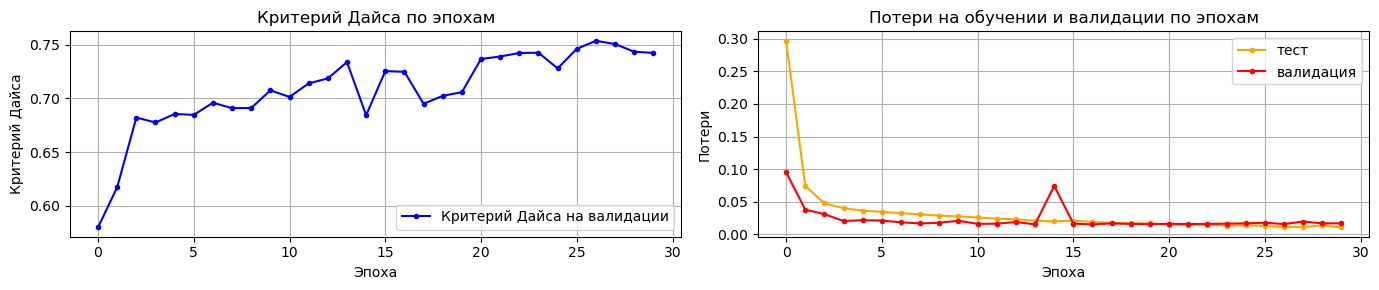

In [ ]:
# Визуализация потерь и критерий Дайса
plt.figure(figsize=(14, 3))

# График f1 - метрики
plt.subplot(1, 2, 1)
plt.plot(metrics, '.-', label='Критерий Дайса на валидации', color='blue')
plt.xlabel('Эпоха')
plt.ylabel('Критерий Дайса')
plt.title('Критерий Дайса по эпохам')
plt.legend()
plt.grid(True)

# График потерь
plt.subplot(1, 2, 2)
plt.plot(train_loss, '.-', label='тест', color='orange')
plt.plot(val_loss, '.-', label='валидация', color='red')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на обучении и валидации по эпохам')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

__Модель: `U-Net(Resnet50)`/ Коэффициент Дайса взвешенное среднее для $(К_0)$ и $(K_1)$ по четырем классам на валидации 14 эпохи: `0.734`. Модель предсказывала наличие или отсутствия дефектов четырех классов на изображении для каждого пикселя (семантическая сегментация).__


```
train loss: 0.0207 val loss: 0.0154
val_dice: 0.734
val_iou: 0.688
val_dice_pos: [0.    0.    0.619 0.428]
val_dice_neg: [1.    1.    0.891 0.981]
*
```


EPOCHS = 100

EARLY_STOP_PATIENCE = 15

BCELoss(reduction='none'),

Adam(4e-4),

ReduceLROnPlateau(REDUCE_LR_FACTOR = 0.25, REDUCE_LR_PATIENCE = 7, REDUCE_LR_MIN = 1e-6)

**Интерпретация результатов:**

- Коэффициент Дайса (0.734), 14 эпоха. Без регуляризаций;
- В среднем, на переобученной модели самая плохая метрика у 2 класса ввиду сильного дисбаласа в данных;
- На 14 эпохе модель еще не научилась сегментировать дефекты 1 и 2 класса;
- Переобучение после 14 эпохи, лосс на валидации стал возрастать.
- Возмем решение за бейзлайн.


**Дальнейшие действия:**

**1. Исследовательский этап**:

- **Аугментация**: попробовать выравнивание гистограммы контраста, Блюр, добавить резкости, возможно перейти на один входной канал;


- В качеcтве **модели** попробовать EfficientNet-b5/b7 как энкодер и Unet + FPN как декодер (segmentation_models_pytorch);
- В качестве **лосса** взять взвешенную сумму BCELoss и Dice - добавит устойчивость к дисбалансу;
- В качестве **оптимизатора** RAdam, AdamW, SGD с моментумом, + попробовать разный шаг для кодера энкодера + Регуляризация weight decay;
- В качестве **шедуллера** попробовать CosineAnnealingLR;
- Построцессинг: использовать **пороговое кол-во пикселей** для каждого класса (смотри разведочный анализ)
- Работа с **перекрытиями классов**: для того что бы в каждом пикселе был один прогноз дефекта применить удаление площадей классов с более меньшей площадью. Попробовать softmax.


- Собрать **пайплайн**: Т.к. на метрику Дайса влияют ошибки FP, их нужно минимизировать. Следовательно оставим **бинарный классификатор** для определения наличия дефекта на изображении и будем игнорировать предсказания сегментационных моделей для тех изображений, где классификатор не обнаружил дефект. Так же можно для моделей сегментации подбирать порог в зависимости от уверенности классификатора в дефекте. Т.е. понижать его при низком результате классификации чтобы уменьшить вероятность ложноположительных предсказаний.

  Далее применим **мультиклассовый классификатор** и 4 **модели сегментации** каждого класса.

- Что исследовать:

  ! Обязательно попробовать **трансформеры**, начать с подобных, как: Mask2Former, Swin, SegFormer
  https://github.com/lxtGH/Awesome-Segmentation-With-Transformer

  ! Статья про сравнение моделей (в порядке убывания коэффициента Дайса): `Xception`, `U-net`, `Unet++`, `Mask RCNN`, https://norma.ncirl.ie/4432/1/akanshabansal.pdf
  Xception - показала наилучший коэффициент Дайса - 0.927 (не известно как была проведена валидация данных).
  В статье обучали бинарный классификатор предсказывающий наличие дефекта, и использовали многоклассовый классификатор - 4 класса дефекта и 1 на их отсутствие. Xception использовали в качестве классификатора, а для сегментации брали U-Net с предобученной EfficientNetB1. Так же можно попробовать для сегментации в качестве бэкбона взять Xception.

- В конце попробовать **асамблирование** из нескольких моделей, попробовать разные вариации энкодера-декодера;
- Фиксировать все **сиды** экспериментов.

**2 Инфраструктурный этап**:
  
- Вынести наконец-то код из ноутбка, разбить `train_model` на `training_epoch`, `validation_epoch`, `train`, добавить функцию `plot_losses` для отслеживания прогресса лосса и метрики по эпохам на графике.
- **Мониторинг**: как минимум TensorBoard или wandb, как максимум - mlflow;
- **Конфиги** через гидру;
- Перейти на **catalyst** для ускорения обрабработки экспериментов.